# Разработка A/B-тестирования и анализ результатов

- Автор: Зотова Дарья
- Дата: 15.09.2025

### Краткое описание проекта

Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты. Команда разработчиков создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Нужно рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

### Цель и задачи проекта

**Цель:** Проверить эффективность нового алгоритма рекомендаций в приложении, чтобы определить, увеличивает ли он вовлечённость пользователей по сравнению с текущим алгоритмом.

**Задачи:**

1. Проанализировать исторические данные о поведении пользователей для оценки исходного уровня вовлечённости.
2. Определить ключевую метрику эффективности.
3. Сформулировать нулевую и альтернативную гипотезы для A/B-теста. 
4. Рассчитать параметры A/B-теста: размер выборки и длительность эксперимента.
5. Оценить корректность проведения теста, включая сбалансированность экспериментальных групп по количеству пользователей, независимость выборок и равномерность распределения пользователей по категориальным признакам. 
6. Проанализировать результаты эксперимента и дать рекомендации продуктовой команде по внедрению нового алгоритма.

### Описание данных

Данные состоят из трёх датасетов:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям на период 11.08.25 — 23.09.25.
- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 14.10.25.
- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть 14.10.25 — 02.11.25. 

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;
- `session_id` — идентификатор сессии в приложении;
- `session_date` — дата сессии;
- `session_start_ts` — дата и время начала сессии;
- `install_date` — дата установки приложения;
- `session_number` — порядковый номер сессии для конкретного пользователя;
- `registration_flag` — является ли пользователь зарегистрированным;
- `page_counter` — количество просмотренных страниц во время сессии;
- `region` — регион пользователя;
- `device` — тип устройства пользователя;
- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

### Содержимое проекта

1. Работа с историческими данными
   - 1.1. Загрузка данных и знакомство с ними
   - 1.2. Анализ числа регистраций
   - 1.3. Анализ числа просмотренных страниц
   - 1.4. Анализ доли успешных сессий
   - 1.5. Вывод после работы с историческими данными
2. Подготовка к тесту
   - 2.1. Формулировка нулевой и альтернативной гипотез
   - 2.2. Расчёт размера выборки
   - 2.3. Расчёт длительности A/B-теста
   - 2.4. Вывод после подготовки к тесту
3. Мониторинг A/B-теста
   - 3.1. Загрузка данных и знакомство с ними
   - 3.2. Проверка распределения пользователей по группам
   - 3.3. Проверка пересечений пользователей
   - 3.4. Равномерность разделения пользователей по устройствам
   - 3.5. Равномерность распределения пользователей по регионам
   - 3.6. Вывод после проверки A/B-теста
4. Проверка результатов A/B-теста
   - 4.1. Загрузка данных и знакомство с ними
   - 4.2. Проверка корректности результатов теста
   - 4.3. Сравнение доли успешных сессий
   - 4.4. Проверка статистической значимости изменения ключевой метрики
   - 4.5. Вывод по результатам A/B-эксперимента

---

## Работа с историческими данными

### Загрузка данных и знакомство с ними

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Выгружаем исторические данные
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
# Выводим первые строки датафрейма на экран
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
# Выводим базовую информацию о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


Датасет `sessions_project_history.csv` содержит 10 столбцов и 435 924 строки, в которых представлены исторические данные по всем сессиям пользователей на период 11.08.25 — 23.09.25

После первичного анализа данных можно сделать следующие выводы:

- Названия столбцов соответствуют их сожержанию.
- Типы столбцов корректны, кроме столбцов с временными данными`session_date`, `session_start_ts` и `install_date`.
- На первый взгляд столбцы не содержат пропуски.
- Значения в столбцах соответствуют своему описанию.

---

### Анализ числа регистраций

Динамика регистраций позволяет выявить сезонные колебания, пиковые дни и периоды активности пользователей. Это важно для планирования теста: нужно убедиться, что эксперимент не совпадёт с аномальными всплесками активности, которые могут исказить результаты. Посмотрим по историческим данным, как менялось число регистраций за представленный период.

Агрегируем данные и рассчитаем число уникальных и зарегистрированных пользователей для каждого дня. Для упрощения примем, что у каждого пользователя в течение дня максимум одна сессия, а статус регистрации не изменяется в течение дня.

In [40]:
# Формируем таблицу на уровне "день-пользователь":
# - группируем по дате и пользователю,
# - берём максимум по registration_flag (чтобы для каждого пользователя в день статус был 0 или 1).

sessions_history_agg = sessions_history.groupby(['session_date', 'user_id'])['registration_flag'].max().reset_index()

# Проверяем результат
sessions_history_agg.head()

,session_date,user_id,registration_flag
0,2025-08-11,00044C43F22EF7D7,0
1,2025-08-11,00058016FFE49A8B,0
2,2025-08-11,000C43350743C70D,0
3,2025-08-11,00152F90B456FCED,0
4,2025-08-11,001780C4B5F0E607,0


In [6]:
# Считаем ежедневные значения:
# - количество уникальных пользователей в день,
# - количество зарегистрированных пользователей (сумма по registration_flag),
# - долю зарегистрированных пользователей от общего количества пользователей (среднее по registration_flag).

sessions_history_users_count = (
    sessions_history_agg
    .groupby('session_date')
    .agg(users_count=('user_id', 'count'),
        registered_count=('registration_flag', 'sum'),
        registered_share=('registration_flag', 'mean'))
).reset_index()

# Выводим результат
sessions_history_users_count

,session_date,users_count,registered_count,registered_share
0,2025-08-11,3919,169,0.043123
1,2025-08-12,6056,336,0.055482
2,2025-08-13,8489,464,0.054659
3,2025-08-14,10321,625,0.060556
4,2025-08-15,14065,840,0.059723
5,2025-08-16,12205,916,0.075051
6,2025-08-17,11200,833,0.074375
7,2025-08-18,10839,860,0.079343
8,2025-08-19,12118,831,0.068576
9,2025-08-20,13514,1008,0.074589


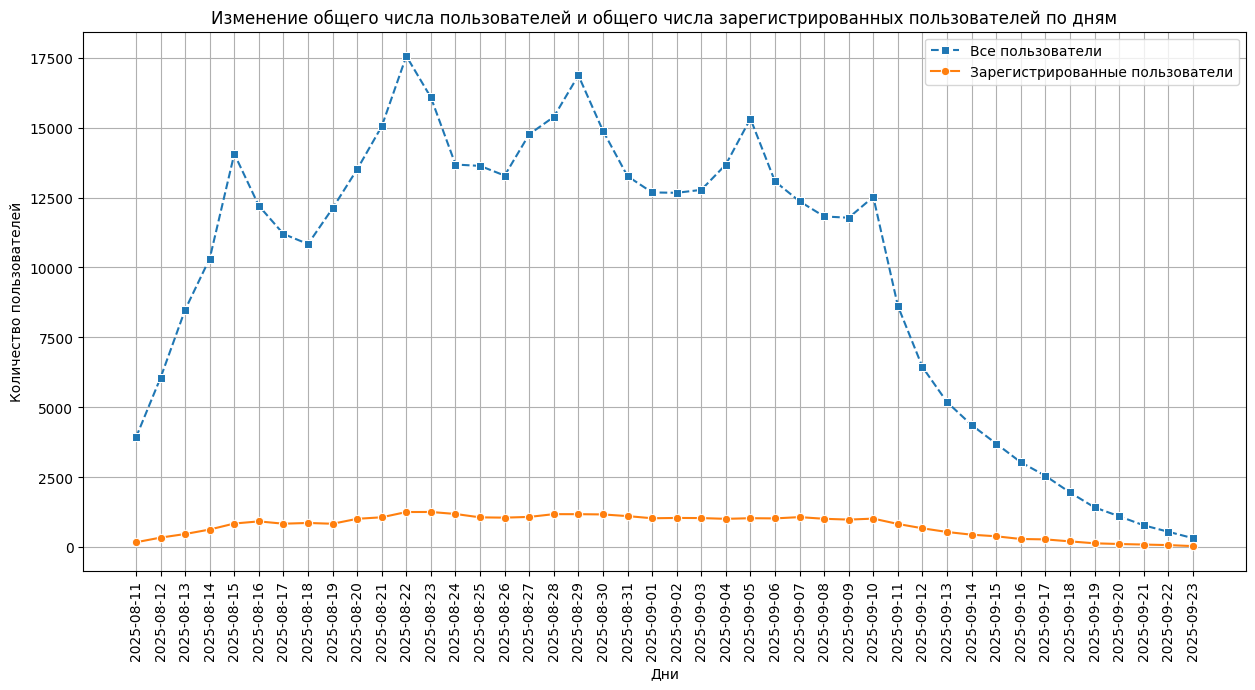

In [7]:
# Строим линейный график общего числа пользователей и общего числа зарегистрированных пользователей по дням

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 7))

# Строим линейный график — количество уникальных пользователей в день
sns.lineplot(
    data=sessions_history_users_count,
    x='session_date',
    y='users_count',
    label='Все пользователи',
    marker='s',
    linestyle='--'
)

# Строим линейный график — количество зарегистрированных пользователей в день
sns.lineplot(
    data=sessions_history_users_count,
    x='session_date',
    y='registered_count',
    label='Зарегистрированные пользователи',
    marker='o',
    linestyle='-' 
)

# Заголовок и подписи осей
plt.title("Изменение общего числа пользователей и общего числа зарегистрированных пользователей по дням")
plt.xlabel("Дни")
plt.ylabel("Количество пользователей")

# Поворачиваем подписи на оси X вертикально
plt.xticks(rotation=90)

# Настраиваем легенду
plt.legend()

# Добавляем сетку
plt.grid()

# Выводим график
plt.show()

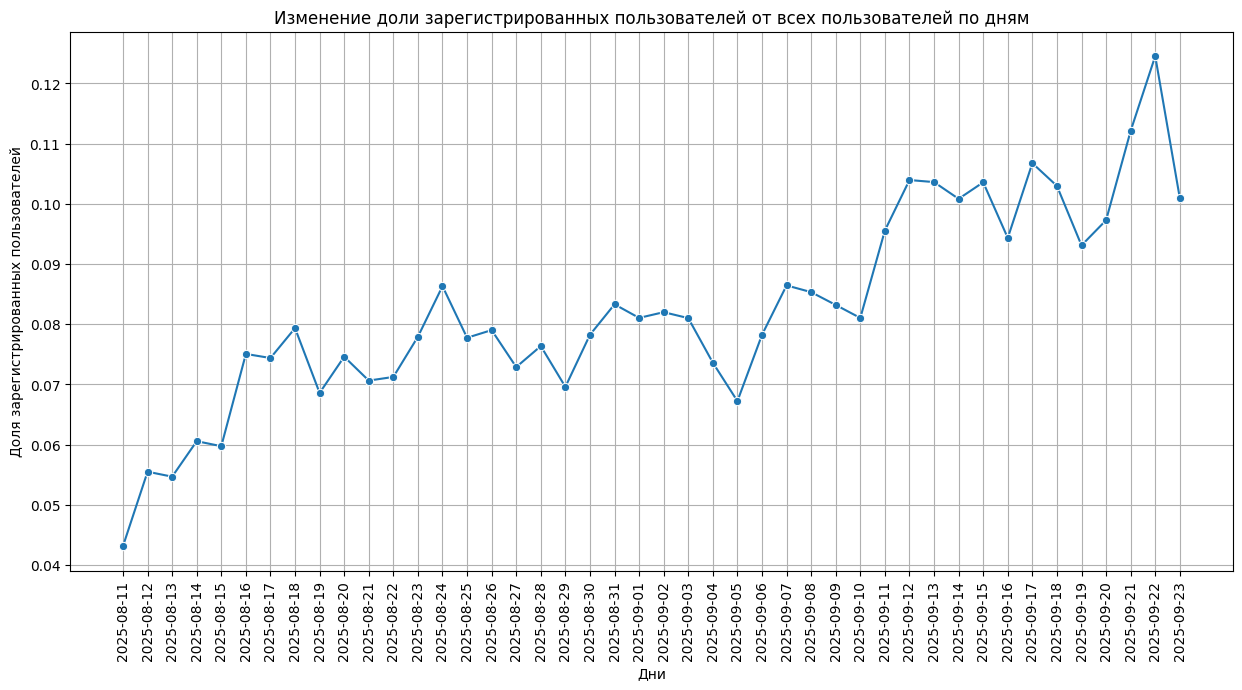

In [8]:
# Строим линейный график доли зарегистрированных пользователей от всех пользователей по дням

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 7))

# Строим линейный график
sns.lineplot(
    data=sessions_history_users_count,
    x='session_date',
    y='registered_share',
    marker='o',
    linestyle='-'
)

# Заголовок и подписи осей
plt.title("Изменение доли зарегистрированных пользователей от всех пользователей по дням")
plt.xlabel("Дни")
plt.ylabel("Доля зарегистрированных пользователей")

# Поворачиваем подписи на оси X вертикально
plt.xticks(rotation=90)

# Добавляем сетку
plt.grid()

# Выводим график
plt.show()

Аудитория приложения сначала быстро росла и достигла пика 22 августа (около 17,5 тыс. пользователей), после чего началось устойчивое снижение. При этом доля регистраций последовательно увеличивалась с 4% до 10–12%, что говорит о росте конверсии: пользователей стало меньше, но среди них больше тех, кто регистрируется. По дням недели активность распределена неравномерно: максимум по пользователям наблюдается в четверг–пятницу, по регистрациям — в пятницу–субботу, а минимальные значения приходятся на воскресенье-понедельник.

---

### Анализ числа просмотренных страниц

Анализ числа просмотренных страниц поможет определить типичное поведение пользователей и выбрать реалистичный порог «успешной сессии» (например, просмотр не менее 4 страниц), доли которых мы будем сравнивать в рамках A/B-теста.

In [9]:
# Находим количество сессий для каждого значения количества просмотренных страниц
sessions_history_sessions_count = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
sessions_history_sessions_count = sessions_history_sessions_count.rename(columns={'session_id': 'sessions_count'})
sessions_history_sessions_count

,page_counter,sessions_count
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


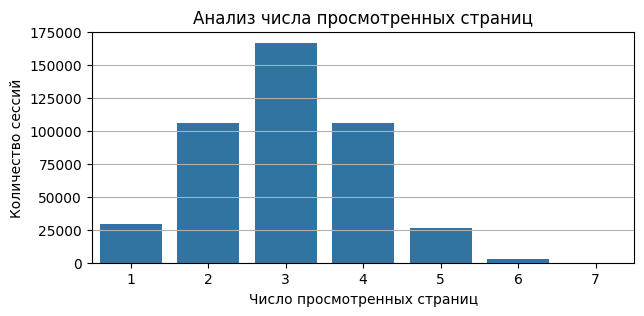

In [54]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим горизонтальный barplot
sns.barplot(
    data=sessions_history_sessions_count,
    x='page_counter',
    y='sessions_count'
)

# Заголовок и подписи осей
plt.title('Анализ числа просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')

# Добавляем сетку
plt.grid(axis='y')

# Выводим график
plt.show()

Пользователи чаще всего просматривают 3 страницы за сессию (105569 сессий), активность резко падает после 4 страниц.

---

### Анализ доли успешных сессий

Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта. Его анализ позволит нам оценить базовое значение метрики, от которого мы будем отталкиваться в A/B-тесте.

В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

In [11]:
# Создаём функцию для заполнения столбца good_session
def is_good_session(row):
    if row['page_counter'] >= 4:
        return 1
    else:
        return 0
    
# Применяем функцию к датафрейму
sessions_history['good_session'] = sessions_history.apply(is_good_session, axis=1)

# Проверяем результат
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [12]:
# Готовим данные к визуализации
sessions_history_good_session = sessions_history.groupby('session_date')['good_session'].mean().reset_index()
sessions_history_good_session = sessions_history_good_session.rename(columns={'good_session': 'good_session_share'})
sessions_history_good_session

,session_date,good_session_share
0,2025-08-11,0.312835
1,2025-08-12,0.302015
2,2025-08-13,0.306750
3,2025-08-14,0.316055
4,2025-08-15,0.304941
5,2025-08-16,0.306186
6,2025-08-17,0.317589
7,2025-08-18,0.310545
8,2025-08-19,0.312840
9,2025-08-20,0.306941


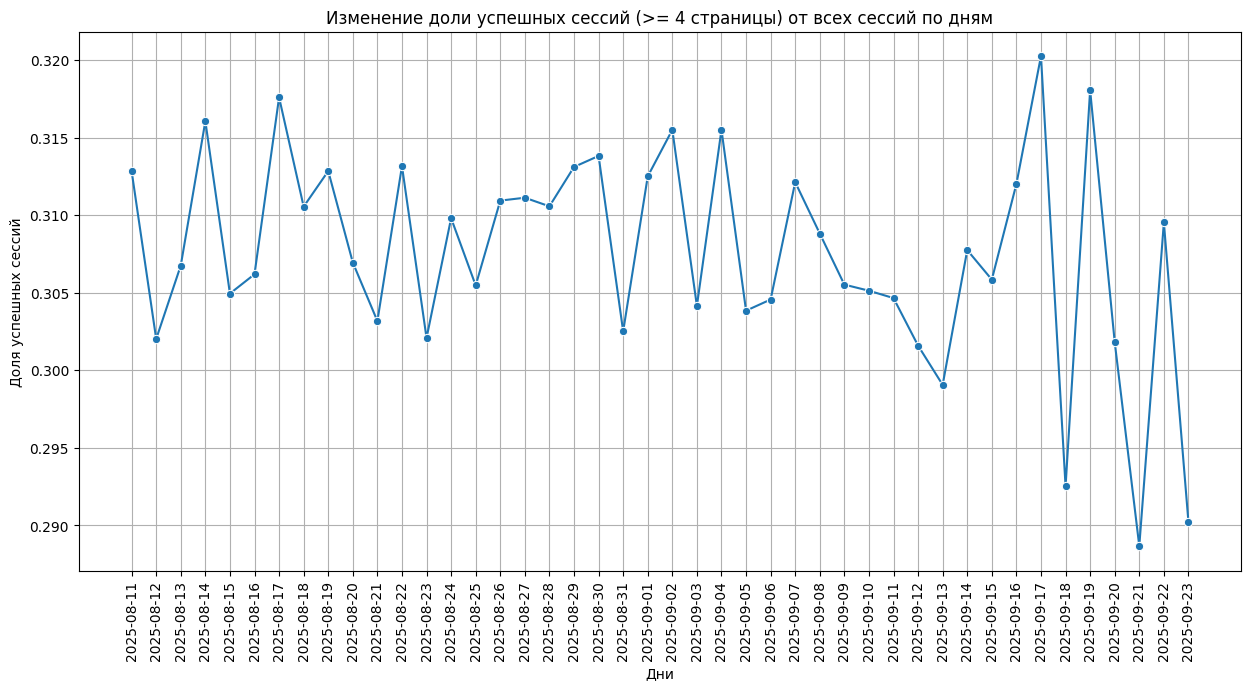

In [13]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 7))

# Строим линейный график
sns.lineplot(
    data=sessions_history_good_session,
    x='session_date',
    y='good_session_share',
    marker='o',
    linestyle='-'
)

# Заголовок и подписи осей
plt.title("Изменение доли успешных сессий (>= 4 страницы) от всех сессий по дням")
plt.xlabel("Дни")
plt.ylabel("Доля успешных сессий")

# Поворачиваем подписи на оси X вертикально
plt.xticks(rotation=90)

# Добавляем сетку
plt.grid()

# Выводим график
plt.show()

Доля успешных сессий (>=4 страницы) по дням остаётся относительно стабильной и колеблется в диапазоне примерно 29–32%.

---

### Вывод после работы с историческими данными

По историческим данным видно, что активность пользователей приложения постепенно снижается после августовского пика, при этом конверсия в регистрацию растёт — аудитория становится более целевой и заинтересованной. Поведение пользователей относительно стабильное: большинство ограничивается тремя просмотрами за сессию, а доля «успешных» сессий (с четырьмя и более просмотрами) держится на уровне 29–32% без значимых колебаний.

Это говорит о том, что пользовательская активность и глубина взаимодействия с контентом относительно устойчивы, поэтому эксперимент можно проводить, не опасаясь сильных внешних и сезонных искажений. Но из-за снижения числа пользователей важно проверить, что в обе группы попадёт достаточно трафика, чтобы результаты теста были надёжными.

---

## Подготовка к тесту

Мы определились, что целевой метрикой A/B-теста будет доля успешных сессий (просмотр не менее 4 страниц за сессию). 

При планировании теста необходимо проделать ещё несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы
- Рассчитать необходимый размер выборки.
- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

---

### Формулировка нулевой и альтернативной гипотез

Сформулируем нулевую и альтернативную гипотезы:

**Нулевая гипотеза (H₀):**
Доля успешных сессий (>= 4 страницы) у пользователей, использующих новый алгоритм рекомендаций, не выше, чем у пользователей, не использующих новый алгоритм.

**Альтернативная гипотеза (H₁):**
Доля успешных сессий (>= 4 страницы) у пользователей, использующих новый алгоритм рекомендаций, выше, чем у пользователей, не использующих новый алгоритм.

---

### Расчёт размера выборки

Параметры теста:

- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста — 0.8.
- Минимальный детектируемый эффект (MDE) — 3% в относительном выражении.

При расчёте используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [14]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


---

### Расчёт длительности A/B-теста

Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения.

In [48]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при среднем дневном трафике в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при среднем дневном трафике в 9907 пользователей в день составит 9 дней


---

### Вывод после подготовки к тесту

Обобщим информацию о тесте:

**Ключевая метрика:** доля успешных сессий (просмотр не менее 4 страниц за одну сессию).

**Гипотезы:**
- H₀: Доля успешных сессий (>= 4 страниц) у пользователей, использующих новый алгоритм не выше, чем у не использующих.
- H₁: Доля успешных сессий (>= 4 страниц) у пользователей, использующих новый алгоритм выше, чем у не использующих.

**Параметры теста:**
- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста — 0.8.
- Минимальный детектируемый эффект (MDE) — 3% в относительном выражении.

**Размер выборки:** 41 040 для каждой группы.

**Длительность теста:** 9 дней при среднем дневном трафике в 9 907 пользователей. Однако нужно учитывать общее снижение аудитории: может потребоваться продлить эксперимент, чтобы набрать необходимое количество пользователей.

---

## Мониторинг А/В-теста

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

### Загрузка данных и знакомство с ними

In [16]:
# Выгружаем данные за первые три дня теста
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [17]:
# Выводим первые строки датафрейма на экран
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [18]:
# Выводим базовую информацию о датафрейме
sessions_test_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


Датасет `sessions_project_test_part.csv` содержит 11 столбцов и 3 130 строк, в которых представлены данные за первый день проведения A/B-теста, то есть за 14.10.25.

После первичного анализа данных можно сделать следующие выводы:

- Типы столбцов корректны, кроме столбцов с временными данными `session_date`, `session_start_ts` и `install_date`.
- На первый взгляд столбцы не содержат пропуски.

---

### Проверка распределения пользователей по группам

In [19]:
# Рассчитываем количество уникальных пользователей в каждой из экспериментальных групп
sessions_test_part_agg = sessions_test_part.groupby(['test_group', 'session_date'])['user_id'].nunique().reset_index()
sessions_test_part_agg = sessions_test_part_agg.rename(columns={'user_id': 'users_count'})
sessions_test_part_agg

,test_group,session_date,users_count
0,A,2025-10-14,1477
1,B,2025-10-14,1466


In [20]:
# Рассчитываем процентную разницу в количестве пользователей в группах A и B
user_counts_a = sessions_test_part_agg.loc[sessions_test_part_agg['test_group'] == 'A', 'users_count'].iloc[0]
user_counts_b = sessions_test_part_agg.loc[sessions_test_part_agg['test_group'] == 'B', 'users_count'].iloc[0]

P = round(100 * abs(user_counts_a - user_counts_b) / user_counts_a, 2)
P

np.float64(0.74)

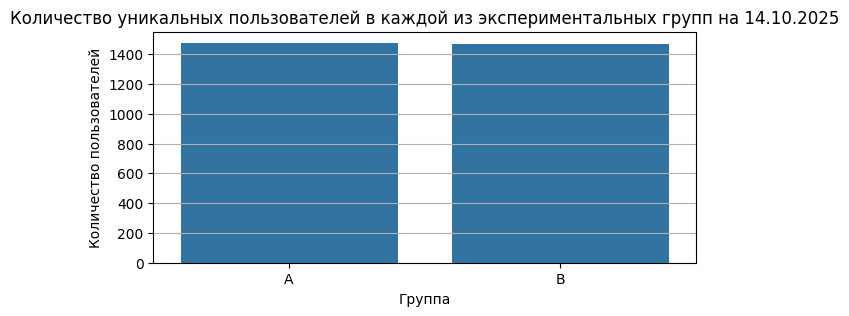

In [49]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму
sns.barplot(
    data=sessions_test_part_agg,
    x='test_group',
    y='users_count'
)

# Заголовок и подписи осей
plt.title("Количество уникальных пользователей в каждой из экспериментальных групп на 14.10.2025")
plt.xlabel("Группа")
plt.ylabel("Количество пользователей")


# Добавляем сетку
plt.grid(axis='y')

# Выводим график
plt.show()

Между группами A (1477 человек) и B (1466 человек) разница всего 11 пользователей (~0,7%), это практически баланс.

---

### Проверка пересечений пользователей

Помимо проверки равенства количества пользователей в экспериментальных группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

In [22]:
# Найдём пользователей, которые встречаются одновременно в группах A и B
a_users = sessions_test_part.loc[sessions_test_part['test_group'] == 'A', 'user_id']
b_users = sessions_test_part.loc[sessions_test_part['test_group'] == 'B', 'user_id']

intersection = list(set(a_users) & set(b_users))
len(intersection)

0

Пользователей, встречающихся сразу в обеих экспериментальных группах не обнаружено.

---

### Равномерность разделения пользователей по устройствам

Полезно также убедиться в том, что пользователи равномерно распределены по типам устройств.

In [23]:
# Готовим данные к визуализации
a_devices = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique().reset_index()
a_devices['share'] = a_devices['user_id'] / a_devices['user_id'].sum()
a_devices

,device,user_id,share
0,Android,656,0.444144
1,Mac,156,0.105619
2,PC,369,0.249831
3,iPhone,296,0.200406


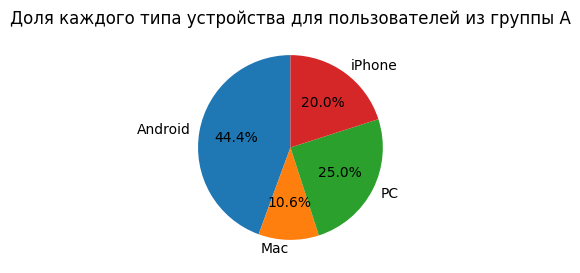

In [50]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))


# Строим круговую диаграмму
labels = a_devices['device']
sizes = a_devices['share']

plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%', 
    startangle=90
)

# Добавляем заголовок
plt.title('Доля каждого типа устройства для пользователей из группы A')

# Выводим график
plt.show()

In [25]:
# Готовим данные к визуализации
b_devices = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique().reset_index()
b_devices['share'] = b_devices['user_id'] / b_devices['user_id'].sum()
b_devices

,device,user_id,share
0,Android,668,0.455662
1,Mac,148,0.100955
2,PC,381,0.259891
3,iPhone,269,0.183492


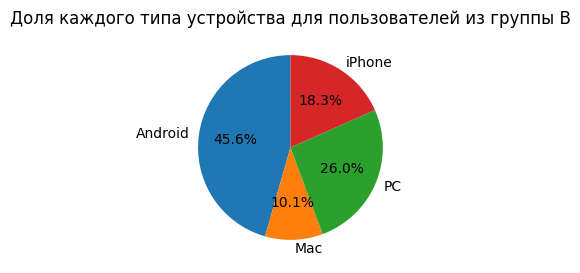

In [51]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))


# Строим круговую диаграмму
labels = b_devices['device']
sizes = b_devices['share']

plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%', 
    startangle=90
)

# Добавляем заголовок
plt.title('Доля каждого типа устройства для пользователей из группы B')

# Выводим график
plt.show()

В обеих экспериментальных группах пользователи распределены по устройствам приблизительно равномерно: 
- Android: около 44% в A и 46% в B,
- PC: около 25% в A и 26% в B,
- iPhone: около 20% в A и 18% в B,
- Mac: около 11% в A и 10% в B.

---

### Равномерность распределения пользователей по регионам

Теперь убедимся, что пользователи равномерно распределены по регионам.

In [27]:
# Готовим данные к визуализации
a_region = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique().reset_index()
a_region['share'] = a_region['user_id'] / a_region['user_id'].sum()
a_region

,region,user_id,share
0,CIS,644,0.436019
1,EU,224,0.151659
2,MENA,609,0.412322


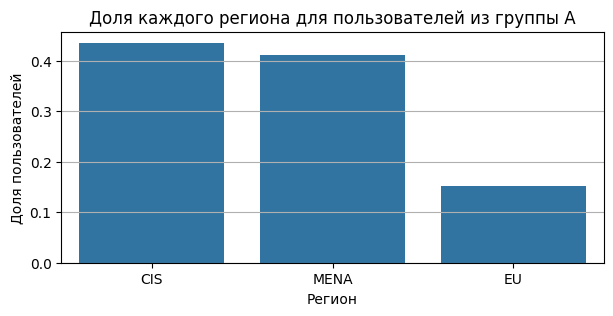

In [52]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму
sns.barplot(
    data=a_region,
    x='region',
    y='share',
    order=a_region.sort_values('share', ascending=False)['region']
)

# Заголовок и подписи осей
plt.title("Доля каждого региона для пользователей из группы A")
plt.xlabel("Регион")
plt.ylabel("Доля пользователей")


# Добавляем сетку
plt.grid(axis='y')

# Выводим график
plt.show()

In [29]:
# Готовим данные к визуализации
b_region = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique().reset_index()
b_region['share'] = b_region['user_id'] / b_region['user_id'].sum()
b_region

,region,user_id,share
0,CIS,645,0.439973
1,EU,217,0.148022
2,MENA,604,0.412005


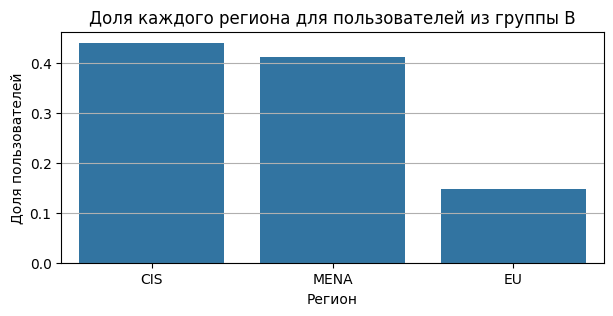

In [53]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму
sns.barplot(
    data=b_region,
    x='region',
    y='share',
    order=b_region.sort_values('share', ascending=False)['region']
)

# Заголовок и подписи осей
plt.title("Доля каждого региона для пользователей из группы B")
plt.xlabel("Регион")
plt.ylabel("Доля пользователей")


# Добавляем сетку
plt.grid(axis='y')

# Выводим график
plt.show()

В обеих экспериментальных группах пользователи распределены по регионам равномерно: 
- CIS (около 44%),
- MENA (около 41%),
- EU (около 15%).

---

### Вывод после проверки A/B-теста

После проверки корректности проведения A/B-теста можно сделать следующие выводы:

**Различие в количестве пользователей:**
Между группами A (1477 человек) и B (1466 человек) разница составляет всего 11 пользователей (~0,7%), что практически несущественно. Количество пользователей в группах можно считать сбалансированным.

**Независимость выборок:**
Пользователи, встречающиеся одновременно в тестовой и контрольной группах, не обнаружены, следовательно, выборки являются независимыми.

**Распределение по категориальным переменным:**

- По устройствам: пользователи распределены приблизительно равномерно: Android (A: 44%, B: 46%), PC (A: 25%, B: 26%), iPhone (A: 20%, B: 18%), Mac (A: 11%, B: 10%).

- По регионам: распределение также сбалансировано: CIS (44%), MENA (41%), EU (15%).

**Заключение:**
Все условия корректного A/B-теста соблюдены: группы сбалансированы по количеству пользователей, выборки независимы, пересечения нет, а распределение по устройствам и регионам равномерное. Нарушений в проведении теста не выявлено, тест проходит корректно.

## Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни эксперимента. Проверим корректность теста и проанализируем результаты.

### Загрузка данных и знакомство с ними

In [31]:
# Выгружаем данные за весь период A/B-теста
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [32]:
# Выводим первые строки датафрейма на экран
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [33]:
# Выводим базовую информацию о датафрейме
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


Датасет `sessions_project_test.csv` содержит 11 столбцов и 100 005 строк, в которых представлены данные за весь период проведения A/B-теста, то есть 14.10.25 — 02.11.25.

После первичного анализа данных можно сделать следующие выводы:

- Типы столбцов корректны, кроме столбцов с временными данными `session_date`, `session_start_ts` и `install_date`.
- На первый взгляд столбцы не содержат пропуски.

Создадим дополнительный столбец `good session` для подсчёта ключевой метрики.

In [34]:
# Создаём дополнительный столбец good_session
sessions_test['good_session'] = sessions_test.apply(is_good_session, axis=1)

# Проверяем результат
sessions_test.sample(n=5, random_state=45)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
69766,F8CF53F32D4E00A8,38DD5A3495CEF7BA,2025-10-17,2025-10-17 18:33:46,2025-10-17,1,0,2,CIS,Mac,B,0
12971,16752876AF7A5185,0BACBDD1F9FEDB2E,2025-10-20,2025-10-20 17:16:25,2025-10-19,2,0,3,CIS,iPhone,B,0
20652,F1225DA128254F58,A65DE5CD14FD84AD,2025-10-20,2025-10-20 14:57:04,2025-10-19,2,0,1,MENA,Android,B,0
75710,300AD324EFB9AC91,7D21458909D84AAD,2025-10-20,2025-10-20 18:04:57,2025-10-20,1,0,4,CIS,iPhone,B,1
44030,F1DD57D2DB1C6EBF,3A378F1F9E26459F,2025-10-21,2025-10-21 17:55:52,2025-10-16,2,1,4,MENA,PC,B,1


### Проверка корректности результатов теста

Перед анализом ключевой метрики важно убедиться, что тест проведён корректно и сравниваются сопоставимые группы. Рассчитаем количество уникальных сессий по дням для обеих тестовых групп и проверим, что различия между ними отсутствуют или не являются статистически значимыми. Для проверки используем статистический тест на равенство средних двух выборок.

In [42]:
# Считаем количетво уникальных сессий по дням для группы A
sessions_test_a_sessions = (
    sessions_test[sessions_test['test_group'] == 'A']
    .groupby('session_date')
    ['session_id'].nunique()
    .reset_index()
)
sessions_test_a_sessions

,session_date,session_id
0,2025-10-14,1502
1,2025-10-15,2235
2,2025-10-16,3280
3,2025-10-17,4089
4,2025-10-18,5013
5,2025-10-19,6535
6,2025-10-20,5837
7,2025-10-21,3927
8,2025-10-22,3083
9,2025-10-23,2470


In [43]:
# Считаем количетво уникальных сессий по дням для группы B
sessions_test_b_sessions = (
    sessions_test[sessions_test['test_group'] == 'B']
    .groupby('session_date')
    ['session_id'].nunique()
    .reset_index()
)
sessions_test_b_sessions

,session_date,session_id
0,2025-10-14,1628
1,2025-10-15,2283
2,2025-10-16,3241
3,2025-10-17,4054
4,2025-10-18,5059
5,2025-10-19,6779
6,2025-10-20,6089
7,2025-10-21,3981
8,2025-10-22,3111
9,2025-10-23,2548


Сформулируем нулевую и альтернативную гипотезы:

**Нулевая гипотеза (H₀):**
В среднем количество уникальных дневных сессий в группе А равно количеству сессий в группе B.

**Альтернативная гипотеза (H₁):**
В среднем количество уникальных дневных сессий в группе А отличается от количества сессий в группе B.

In [37]:
alpha = 0.05

a_sessions_mean = sessions_test_a_sessions['session_id'].mean()
b_sessions_mean = sessions_test_b_sessions['session_id'].mean()

print(f'Среднее дневное количество сессий в группе A: {round(a_sessions_mean)}')
print(f'Среднее дневное количество сессий в группе B: {round(b_sessions_mean)}')
print('')

# Применяем t-тест Уэлча
stat_welsh_ttest, p_value_welsh_ttest = st.ttest_ind(
    sessions_test_a_sessions['session_id'],
    sessions_test_b_sessions['session_id'],
    equal_var=False,
    alternative='two-sided'
)

if p_value_welsh_ttest > alpha:
    print(f'Полученное значение p_value={round(p_value_welsh_ttest, 2)} больше критического уровня alpha={alpha}.')
    print('Опровергнуть нулевую гипотезу нельзя.')
else:
    print(f'Полученное значение p_value={round(p_value_welsh_ttest, 2)} меньше критического уровня alpha={alpha}.') 
    print('Принимаем альтернативную гипотезу.')

Среднее дневное количество сессий в группе A: 2478
Среднее дневное количество сессий в группе B: 2523

Полученное значение p_value=0.94 больше критического уровня alpha=0.05.
Опровергнуть нулевую гипотезу нельзя.


Таким образом, разница в среднем количестве уникальных дневных сессий в группе A и группе B статистически не значима. Группы сопоставимы.

### Сравнение доли успешных сессий

Мы убедились, что разница в среднем количестве уникальных дневных сессий в группе A и группе B статистически не значима. Можно переходить к анализу ключевой метрики — доли успешных сессий.

Рассчитаем доли успешных сессий для выборок A и B, а также разницу в этом показателе. 

In [44]:
# Вычисляем доли успешных сессий в экспериментальных группах
good_session_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
good_session_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()
difference = round((good_session_b - good_session_a) / good_session_a * 100, 2)

print(f'Доля успешных сессий для выборки A составляет {round(good_session_a * 100, 2)}%.')
print(f'Доля успешных сессий для выборки B составляет {round(good_session_b * 100, 2)}%.')
print(f'Доля успешных сессий в группе B выше на {difference}%, чем в группе A.')

Доля успешных сессий для выборки A составляет 30.77%.
Доля успешных сессий для выборки B составляет 31.83%.
Доля успешных сессий в группе B выше на 3.43%, чем в группе A.


### Проверка статистической значимости изменения ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 3.43% (в относильноном выражении) выше, чем в контрольной. Для принятия решения нужно понять, является ли изменение статистически значимым.

In [47]:
# Применяем Z-тест пропорций

n_a = sessions_test[ # считаем размер группы A
    sessions_test['test_group'] =='A'
].shape[0] 

n_b = sessions_test[ # считаем размер группы B
    sessions_test['test_group'] =='B'
].shape[0] 

m_a = sessions_test[ # считаем кол-во успехов в группе A
    (sessions_test['test_group'] =='A')&(sessions_test['good_session']==1)
].shape[0] 

m_b = sessions_test[ # считаем кол-во успехов в группе B
    (sessions_test['test_group'] =='B')&(sessions_test['good_session']==1)
].shape[0] 

alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest( 
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)

if p_value_ztest > alpha:
    print(f'Полученное значение p_value={p_value_ztest} больше критического уровня alpha={alpha}.')
    print('Не получилось отвергнуть нулевую гипотезу.')
else:
    print(f'Полученное значение p_value={p_value_ztest} меньше критического уровня alpha={alpha}.') 
    print('Отвергаем нулевую гипотезу.')

Полученное значение p_value=0.0001574739988036123 меньше критического уровня alpha=0.05.
Отвергаем нулевую гипотезу.


Таким образом данные дают основание полагать, что доля успешных сессий (>= 4 страницы) у пользователей, использующих новый алгоритм рекомендаций, статистически значимо выше, чем у пользователей, не использующих новый алгоритм.

### Вывод по результатам A/B-эксперимента

По результатам проведённого A/B-эксперимента можно сделать следующие выводы:

**Характеристики эксперимента:**

- Размер выборки: 41 040 пользователей в каждой группе.
- Длительность теста: 19 дней.
- Все условия корректного A/B-теста были соблюдены: группы сбалансированы по численности, выборки независимы, пересечений пользователей нет, распределение по устройствам и регионам равномерное.

**Результаты анализа:**

- Среднее количество уникальных дневных сессий в группах A и B статистически не различается (p-value = 0.94).
- Ключевая метрика — доля успешных сессий (>= 4 страницы):
    - группа A: 30.77%,
    - группа B: 31.83%.
    - разница составила +3.43% (в относильноном выражении) в пользу группы B.
- Полученное значение p-value = 0.00016, что ниже критического уровня α = 0.05. Различие статистически значимо.

**Заключение:**

Новый алгоритм рекомендаций положительно влияет вовлечённость пользователей: доля успешных сессий у пользователей, использующих новый алгоритм, статистически значимо выше, чем у пользователей контрольной группы. Разница составила +3.43% (в относильноном выражении) в пользу группы B. Рекомендуется внедрить новый алгоритм в приложение.